# Analyzing the results of a toy experiment

In this notebook we show how simple it is to (a) aggregate results across experimental runs, and (b) drill down into the details of any individual run

In this notebook, we analyze the results of the experiment, **after** `run.sh` has already been executed.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
from sacred.observers import TinyDbReader
data_path = './output/results'
reader = TinyDbReader(data_path)

In [3]:
meta = reader.fetch_metadata(exp_name='test')
files = reader.fetch_files(exp_name='test')

# 1. Collecting aggregate results

We explain what else is in the meta-data in the next section, but for now we are only concerned with aggregating the configuration for each run, as well as the custom metrics we recorded in `ex.info`

In [4]:
result_df = pd.concat([
    pd.DataFrame([meta[i]['config'] for i in range(len(meta))]), 
    pd.DataFrame([meta[i]['info'] for i in range(len(meta))])],
    axis=1)

For example, we can make a learning curve that shows how our test MSE changes with the size of the training dataset.  Note that `seaborn` has some nice built-in bootstrapping-based methods for calculating confidence intervals for data where we have multiple entries at each value of `x` (in our case, this is aggregating over the random seed).  See [seaborn documentation](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty) for more information.

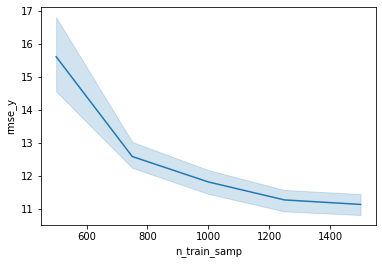

In [7]:
sns.lineplot(x='n_train_samp', y='rmse_y', data=result_df)

plt.show()

Lo and behold, the test error goes down as we increasing the training set size.  In this experiment we only varied a single experimental parameter (namely `n_train_samp`), but you could imagine collecting results from hyperparamter search over a larger set of variables.

# 2. Examining an individual experiment

We'll take a look at an illustrative experiment to see what is recorded on the individual experiment level

In [8]:
exp_idx = 0

## 2a. Source files and artifacts

`fetch_files` will return file connections to all the files which were flagged / stored during experiments.  This includes a link to the python script itself that was used to run the experiment...

In [17]:
# This will print out the contents of `exp.py`, the script used to run the experiment
# files[exp_idx]['sources']['exp.py'].readlines()

... well as any other files that we flagged using `ex.add_artifact`, which in this case includes the saved model file.  This was saved in our script (after we pickled the model) using
```python
ex.add_artifact(file_path, 'model')
```

In [12]:
clf = pickle.load(files[exp_idx]['artifacts']['model'])

In [13]:
clf

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## 2b. Configuration and custom metrics

`meta` contains the configuration for every experiment run

In [14]:
meta[exp_idx]['config']

{'np_seed': 1,
 'n_train_samp': 500,
 'n_test_samp': 1000,
 'n_features': 1000,
 'sparsity': 0.1,
 'n_informative': 100,
 'alpha': 1.0,
 'seed': 123128168}

`meta` also contains the `info` dictionary, which we used in the script to capture custom metrics by writing (for example)
```python
ex.info['R2'] = ...
```

In [15]:
meta[exp_idx]['info']

{'rmse_y': 12.864683946783622, 'rmse_coef': 0.4055952852399809}

There is much more in the `meta` dictionary (including details of the hardware used in the experiment, and many other details).  Run this notebook and see for yourself!